# Exercise 12: PumPy: A minimal model that has it all

In Exercise 12 you will work with a model developed by Cinpla PhD-student Marte Julie Sætra. Being one of few models available that contains ion pumps, we have nicknamed the model PumPy. 

PumPy was constructed to be "a minimal model that has it all". By "has it all" we mean that it (1) has a spatial extension (soma and dendrite), (2) considers both extracellular- and intracellular dynamics, (3) keeps track of all ion concentrations (Na+, K+, Ca2+ and Cl-) and (4) all electrical potentials, (5) accounts for transmembrane, intracellular and extracellular ionic movements due to both diffusion and electrical migration, and (6) can fire action potentials and dendritic calcium spikes. By "minimal" we refer to the spatial extension, i.e., the fact that it has only four (2 intracellular + 2 extracellular) compartments. The model is summarized the Figure below. 

PumPy is essentially an ion-conserving version of the Pinsky-Rinzel model that you can read about in chapter 8.1.2 in Sterratt. The original Pinsky-Rinzel model had two compartments (a somatic and a dendritic), with ion channels for AP firing in the soma, and ion channels for calcium spikes in the dendrite. By adding ion pumps, ion concentration dynamics and extracellular dynamics to this, PumPy gives insight in neuronal processes that are not considered in standard models, namely the homeostatic processes that maintain concentration gradients over the membrane. It can thus also be used to simulate scenarios where these processes fail in maintaining basal conditions. 

<img src="Bilde5.png" width=800>

To solve exercise 12, you will run PumPy by executing the code below. A model run produces as output the transmembrane potential (Figure 1), the extracellular potential outside the soma (Figure 2), and the all ion concentrations in all four comartments (Figure 3-6). To solve the exercise, you will only make minor modifications in the first notebook cell, and the main challenge will be in interpreting the results. 

PumPy is implemented in "pure" Python, and if you prefer, you may download the files and execute them on your own computer and run them there (The files Exercise_12.ipynb and Exercise_12.py contain the same code). Note that the model is somewhat computationally heavy, and you may expect simulations to take roughly 10-20 s per 1 s of biological time.


## Task 1: How high firing rate can a neuron maintain?
__a)__ Run the default simulation setup for 10 s with no stimulus, and verify that the neuron has a stable resting condition. 

__b)__ Run the default simulation setup for 10 s with a 15 pA stimulus to see the neuron fire quite regularly. 

* Comment on the concentration dynamics during the regular firing.
* Zoom in on the action potential, and analyze the dynamics of the membrane potential in the dendrite and the soma. Explain the funny action potential shapes in light of what you can read in Sterratt, chapter 8.1.2.

__c)__ Run the default simulation setup for 10 s with a 45 pA stimulus. Analyze the results, and try to expain why the neuron stops firing after some time. 


## Task 2: The wave of death.
You may recall that neurons are kind of like wind-up toys, i.e., the only process that consumes energy is the winding up (read: "pumping up") of the transmembrane concentration gradients by use of ion pumps. Hence, when the energy supply to the brain is limited, it will affect the pump rates. This happens, for example, during stroke, when the blood flow to the brain is temporarilly abrupted. 

In the experiments by van Rijn Cet al. (2011) [PLoS One 6: e16514], they did EEG recordings in rats that had been decapitated, so that there was no blood supply at all to the brain. Not surprisingly, decapitation eventually lead to a silence in the EEG. More surprisingly, however, after about half a minute of EEG-silence, they observed a new and final outburst of acivity, which they called "the wave of death". Of course, the EEG signal reflects the joint activity of thosands of neurons. However, in Task 2, we will use PumPy to investigate some single-neuron counterpart to it. 

__a)__ Turn off all pumps, and run a long simulation (50 s should be enough to see the trend). Do you see something in the extracellular potential that could correspond to "the wave of death"? By analyzing the output variables, try to give a mechanistic explanation of what happens.

__b)__ What happens after the "wave of death"? Which final (steady-state) values do the ion concentration and membrane potential approach? Do you expect everything to end up "flat", i.e., with equal potential and ion concentrations everywhere? Explain why or why not.

In [1]:
%matplotlib inline

from pinsky_rinzel_pump.pinskyrinzel import *
from pinsky_rinzel_pump.somatic_injection_current import *

# s = soma, d = dendrite, i = intracellular, e = extracellular

T = 309.14 # Temperature [K]
alpha = 2.0 # coupling strength btw soma and dendrite
memb_cap = 3e-2 # membrane capacitance [F/m**2]
Faraday = 9.648e4 # [J]

## Geometry
Memb_area = 616e-12  # membrane area per compartment [m**2]
Vol_i = 1437e-18  # intracellular volume per compartment [m**3]
Vol_e = 718.5e-18  # intracellular volume per compartment [m**3]
sd_dist = 667e-6  # distance btw soma and dend [m]

## Leak conductances [S/m**2]
Na_leak = 0.247
K_leak = 0.5
Cl_leak = 1.0

## Active conductances [S/m**2]
active_on = 1 # To turn on/off active channels
Na_act = 300.*active_on # Na-channel for AP upstroke (only in soma)
K_act = 150.*active_on # K-channel for AP downstroke (only in soma)
Ca_act = 118.*active_on # Calcium channel (only in dendrite)
AHP_act = 8.*active_on # Slow Ca-activated K-channel (only in dendrite)
C_act = 150.*active_on # Fast Ca-activated K-channel (only in dendrite)


## Rates for pumps and co-transporters
pumps_on = 1
rho_rate = 1.87e-6*pumps_on # Na/K ATPase pump
kcc2_rate = 7.00e-7*pumps_on # K/Cl co-transporter
nkcc1_rate = 2.33e-7*pumps_on # Na/K/Cl co-transporter


## Initial membrane potential [V]
initV = -68.8e-3 # [V]

## Initial concentrations [mM]
Na_si0 = 18.
Na_se0 = 139.
K_si0 = 99.
K_se0 = 5.
Cl_si0 = 7.
Cl_se0 = 131.
Ca_si0 = 0.01
Ca_se0 = 1.1

Na_di0 = 18.
Na_de0 = 139.
K_di0 = 99.
K_de0 = 5.
Cl_di0 = 7.
Cl_de0 = 131.
Ca_di0 = 0.01
Ca_de0 = 1.1


# Static residual charges on inside & outside [in concentration, mM of unit charges]
res_i = initV*memb_cap*Memb_area/(Vol_i*Faraday)
res_e = -initV*memb_cap*Memb_area/(Vol_e*Faraday)

# k_res are residual charges
k_res_si0 = Cl_si0 - Na_si0 - K_si0 - 2*Ca_si0 + res_i
k_res_se0 = Cl_se0 - Na_se0 - K_se0 - 2*Ca_se0 + res_e
k_res_di0 = Cl_di0 - Na_di0 - K_di0 - 2*Ca_di0 + res_i
k_res_de0 = Cl_de0 - Na_de0 - K_de0 - 2*Ca_de0 + res_e

# inital condictions for gating variables
n0 = 0.0004
h0 = 0.999
s0 = 0.008
c0 = 0.006
q0 = 0.011
z0 = 1.0

# Simulation setup
simdur = 10 # Total simulation time [s] 
I_stim = 15e-12 # stimulus current [A]

stimfrom = 0 # Start stimulus at [s] 
stimto = simdur # End stimulus at [s]
my_max_step = 1e-4 # Max time step in simulation [s]

In [2]:
## Define differential equations and solve them
print('Starting simulations: This may take some time')
## Set up differential equations
def dkdt(t,k):
    Na_si, Na_se, Na_di, Na_de, K_si, K_se, K_di, K_de, Cl_si, Cl_se, Cl_di, Cl_de, Ca_si, Ca_se, Ca_di, Ca_de, k_res_si, k_res_se, k_res_di, k_res_de, n, h, s, c, q, z = k

    # define cell
    my_cell = PinskyRinzel(T, Na_si, Na_se, Na_di, Na_de, K_si, K_se, K_di, K_de, Cl_si, Cl_se, Cl_di, Cl_de, Ca_si, Ca_se, Ca_di, Ca_de, k_res_si, k_res_se, k_res_di, k_res_de, alpha, Ca_si0, Ca_di0, n, h, s, c, q, z, pumps_on)

    # Set all parameters:
    my_cell.g_Na = Na_act
    my_cell.g_DR = K_act
    my_cell.g_Ca = Ca_act
    my_cell.g_AHP = AHP_act
    my_cell.g_C = C_act
    my_cell.rho = rho_rate
    my_cell.U_kcc2 = kcc2_rate
    my_cell.U_nkcc1 = nkcc1_rate
    my_cell.g_Na_leak = Na_leak 
    my_cell.g_K_leak = K_leak
    my_cell.g_Cl_leak = Cl_leak
    my_cell.alpha = alpha
    my_cell.A_s = Memb_area
    my_cell.A_d = Memb_area
    my_cell.A_i = alpha*Memb_area # intracellular cross section area [m**2]
    my_cell.A_e = alpha*Memb_area/2. # extracellular cross section area [m**2]
    my_cell.V_si = Vol_i
    my_cell.V_di = Vol_i
    my_cell.V_se = Vol_e
    my_cell.V_de = Vol_e
    my_cell.dx = sd_dist
    
    # differential equations
    dNadt_si, dNadt_se, dNadt_di, dNadt_de, dKdt_si, dKdt_se, dKdt_di, dKdt_de, dCldt_si, dCldt_se, dCldt_di, dCldt_de, \
        dCadt_si, dCadt_se, dCadt_di, dCadt_de, dresdt_si, dresdt_se, dresdt_di, dresdt_de = my_cell.dkdt(pumps_on)
    dndt, dhdt, dsdt, dcdt, dqdt, dzdt = my_cell.dmdt()

    # stimulus
    if t > stimfrom and t < stimto:
#        dresdt_si, dresdt_se = somatic_injection_current(my_cell, dresdt_si, dresdt_se, 1.0, I_stim)
        dKdt_si, dKdt_se = somatic_injection_current(my_cell, dKdt_si, dKdt_se, 1.0, I_stim)

    return dNadt_si, dNadt_se, dNadt_di, dNadt_de, dKdt_si, dKdt_se, dKdt_di, dKdt_de, \
        dCldt_si, dCldt_se, dCldt_di, dCldt_de, dCadt_si, dCadt_se, dCadt_di, dCadt_de, \
        dresdt_si, dresdt_se, dresdt_di, dresdt_de, dndt, dhdt, dsdt, dcdt, dqdt, dzdt

## solve
start_time = time.time()
t_span = (0, simdur) # [seconds]

k0 = [Na_si0, Na_se0, Na_di0, Na_de0, K_si0, K_se0, K_di0, K_de0, Cl_si0, Cl_se0, Cl_di0, Cl_de0, Ca_si0, Ca_se0, Ca_di0, Ca_de0, k_res_si0, k_res_se0, k_res_di0, k_res_de0, n0, h0, s0, c0, q0, z0]

sol = solve_ivp(dkdt, t_span, k0, max_step=my_max_step)

## Unpack variables
Na_si, Na_se, Na_di, Na_de, K_si, K_se, K_di, K_de, Cl_si, Cl_se, Cl_di, Cl_de, Ca_si, Ca_se, Ca_di, Ca_de, k_res_si, k_res_se, k_res_di, k_res_de, n, h, s, c, q, z = sol.y
t = sol.t

## calculate membrane potentials and reversal potentials (functions of the simulated concentrations)
my_cell = PinskyRinzel(T, Na_si, Na_se, Na_di, Na_de, K_si, K_se, K_di, K_de, Cl_si, Cl_se, Cl_di, Cl_de, Ca_si, Ca_se, Ca_di, Ca_de, k_res_si, k_res_se, k_res_di, k_res_de, alpha, Ca_si0, Ca_di0, n, h, s, c, q, z, pumps_on)

my_cell.alpha = alpha
my_cell.A_s = Memb_area
my_cell.A_d = Memb_area
my_cell.A_i = alpha*Memb_area # intracellular cross section area [m**2]
my_cell.A_e = alpha*Memb_area/2. # extracellular cross section area [m**2]
my_cell.V_si = Vol_i
my_cell.V_di = Vol_i
my_cell.V_se = Vol_e
my_cell.V_de = Vol_e
my_cell.dx = sd_dist
    
phi_si, phi_se, phi_di, phi_de, phi_sm, phi_dm = my_cell.membrane_potentials()

E_Na_s, E_Na_d, E_K_s, E_K_d, E_Cl_s, E_Cl_d, E_Ca_s, E_Ca_d = my_cell.reversal_potentials()
print('Simulations done!')

Starting simulations: This may take some time
Simulations done!


<IPython.core.display.Javascript object>


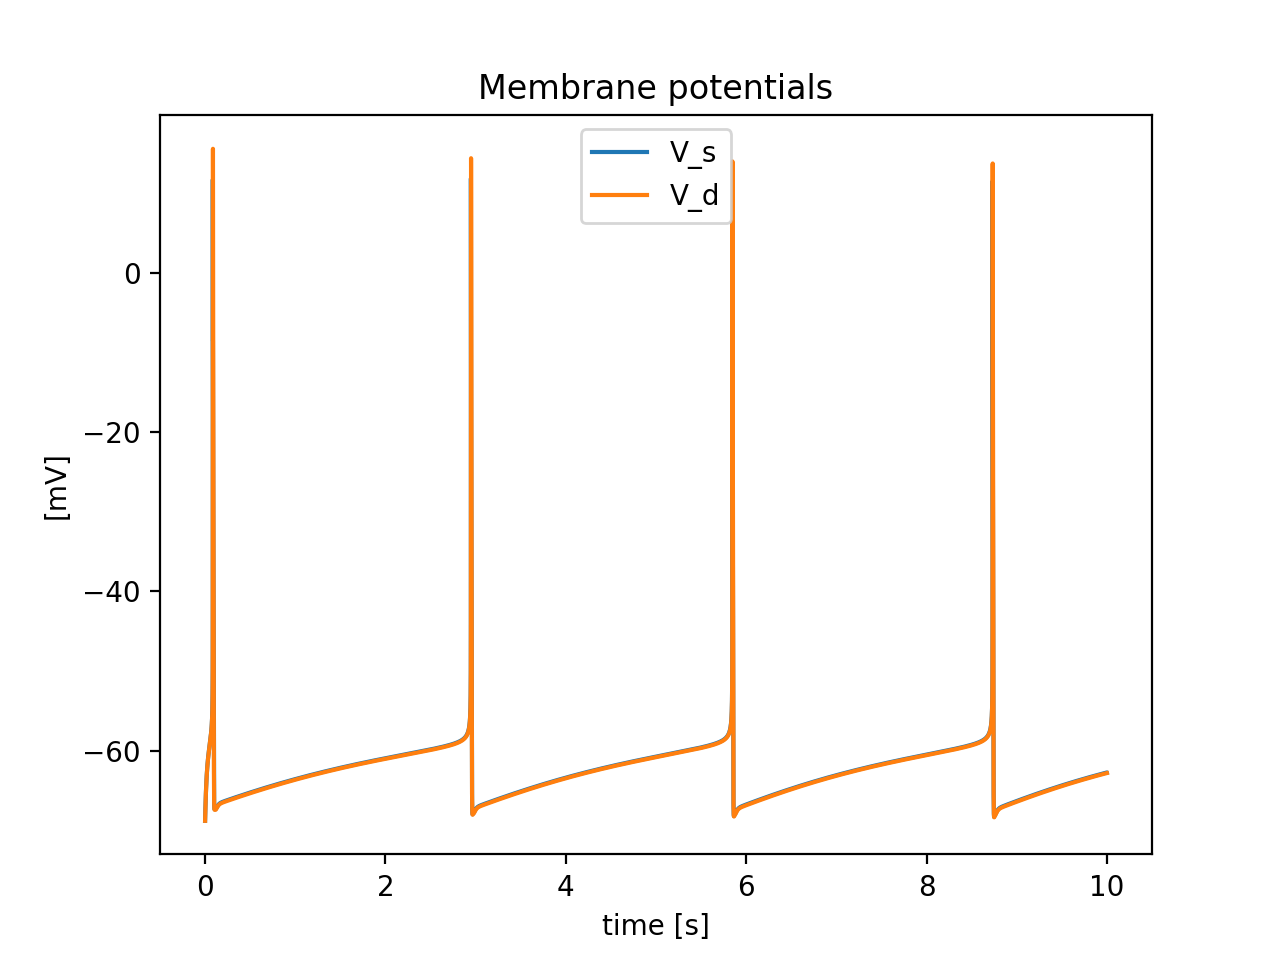

<IPython.core.display.Javascript object>


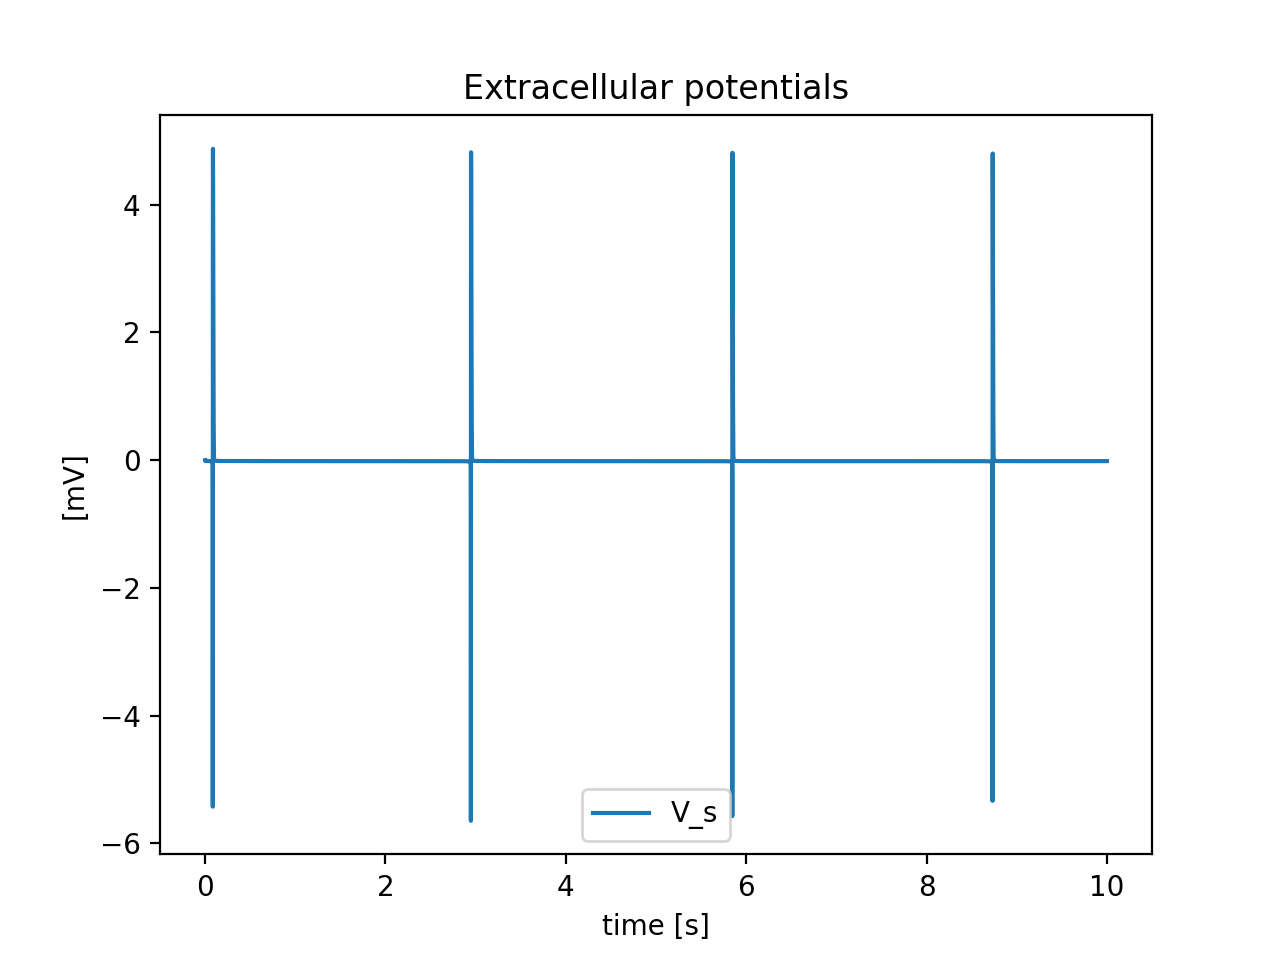

<IPython.core.display.Javascript object>


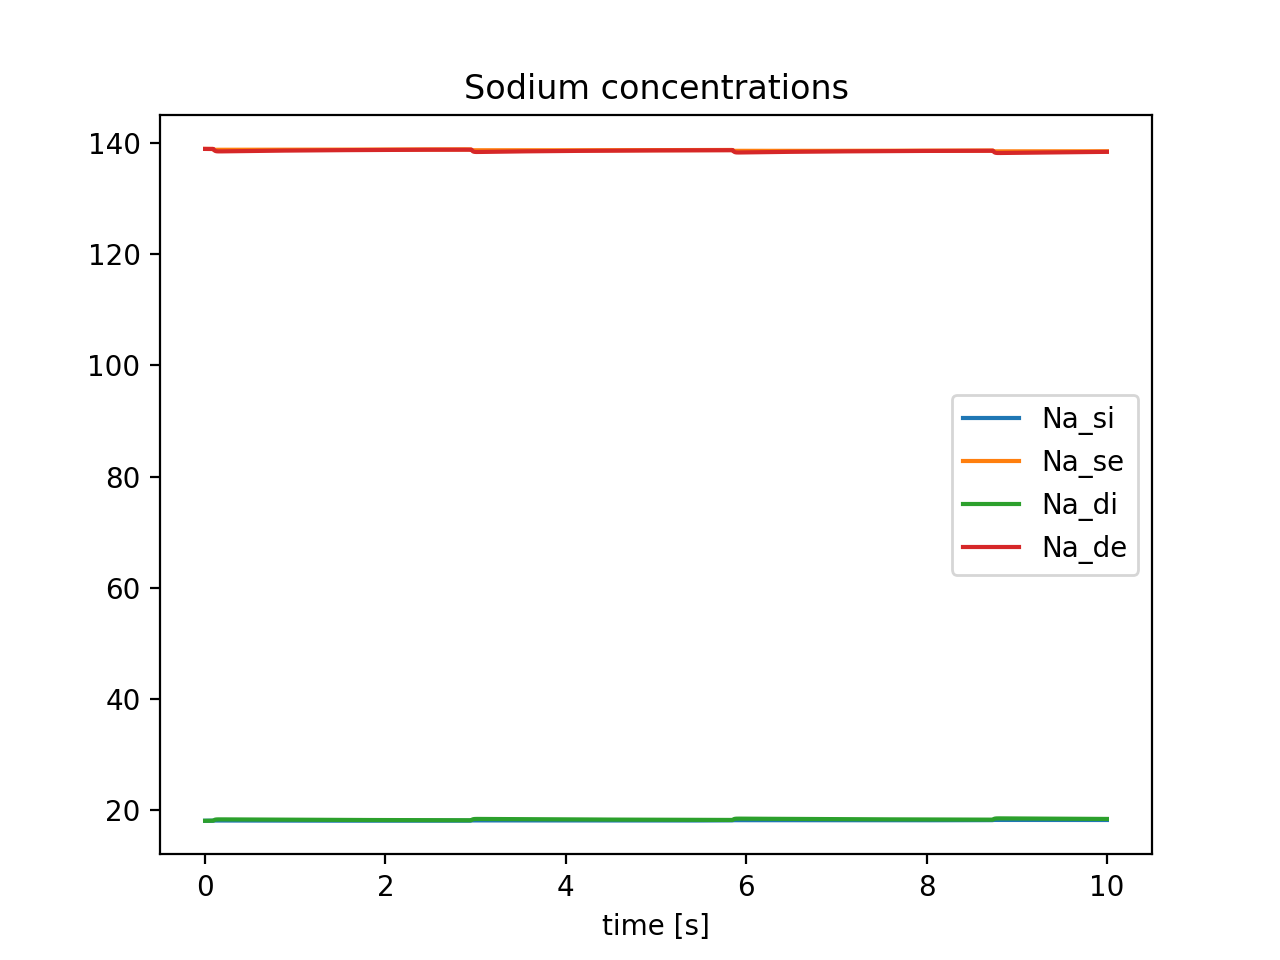

<IPython.core.display.Javascript object>


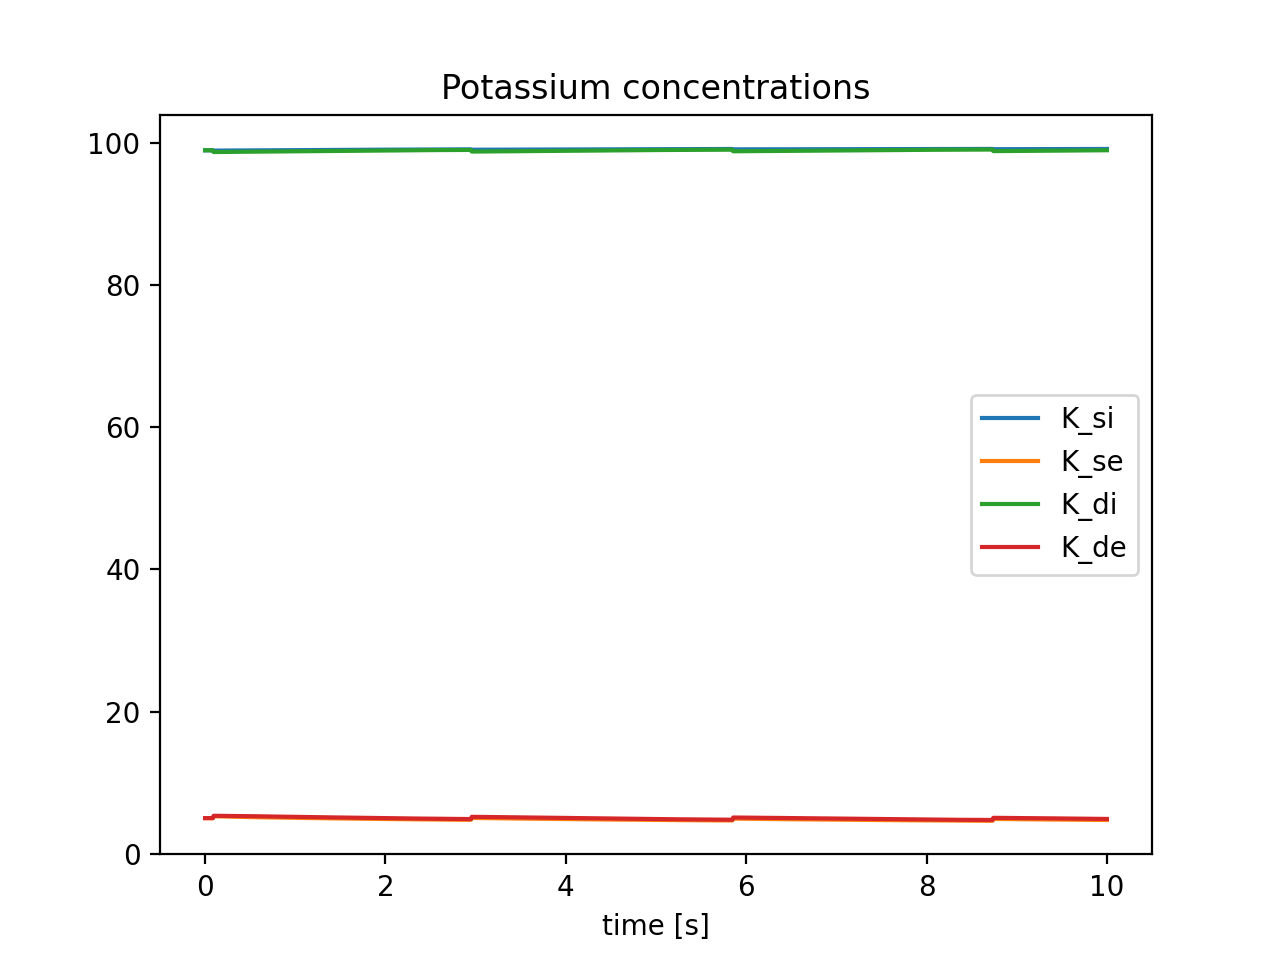

<IPython.core.display.Javascript object>


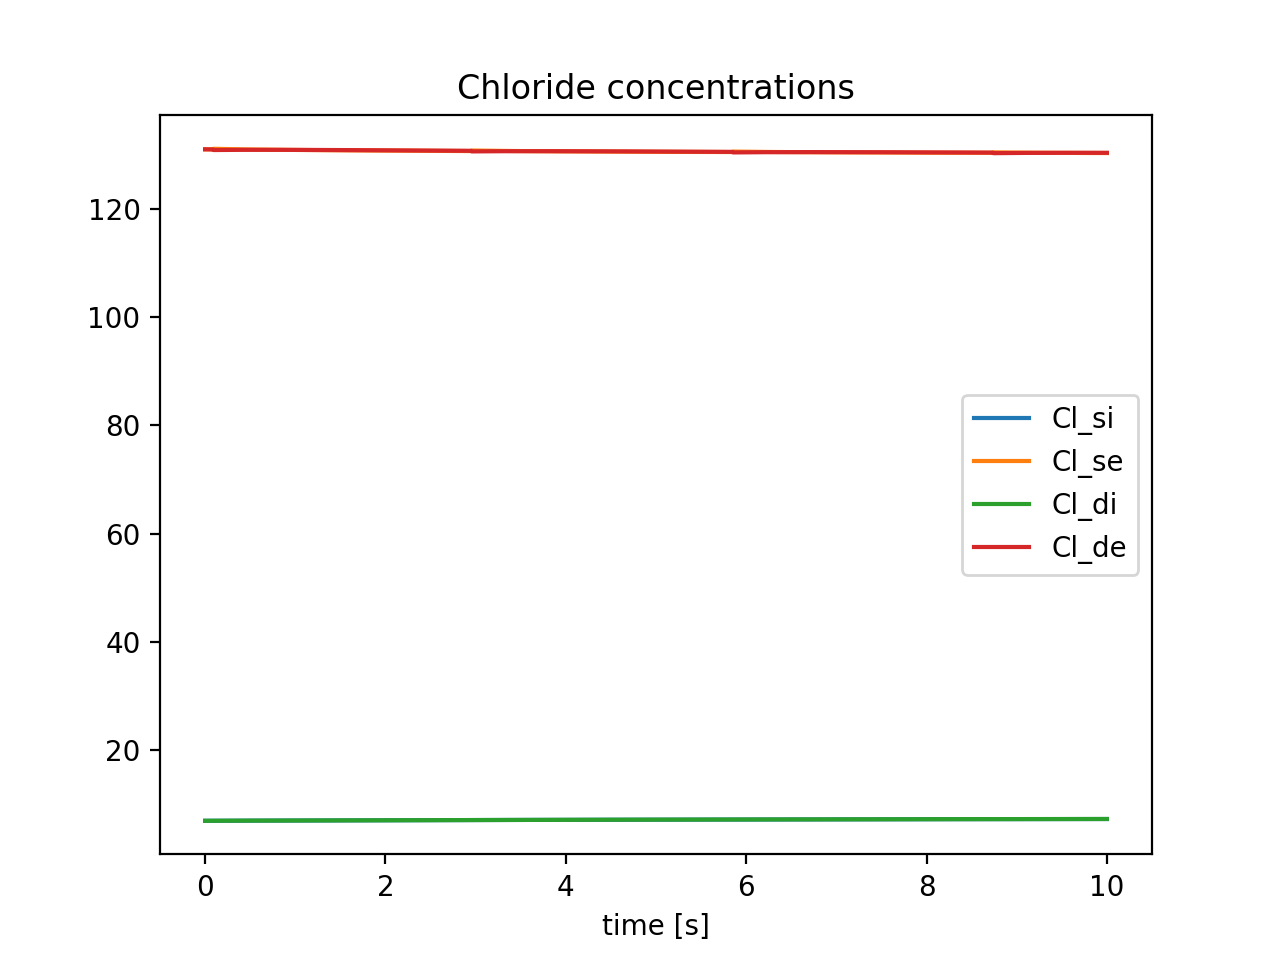

<IPython.core.display.Javascript object>


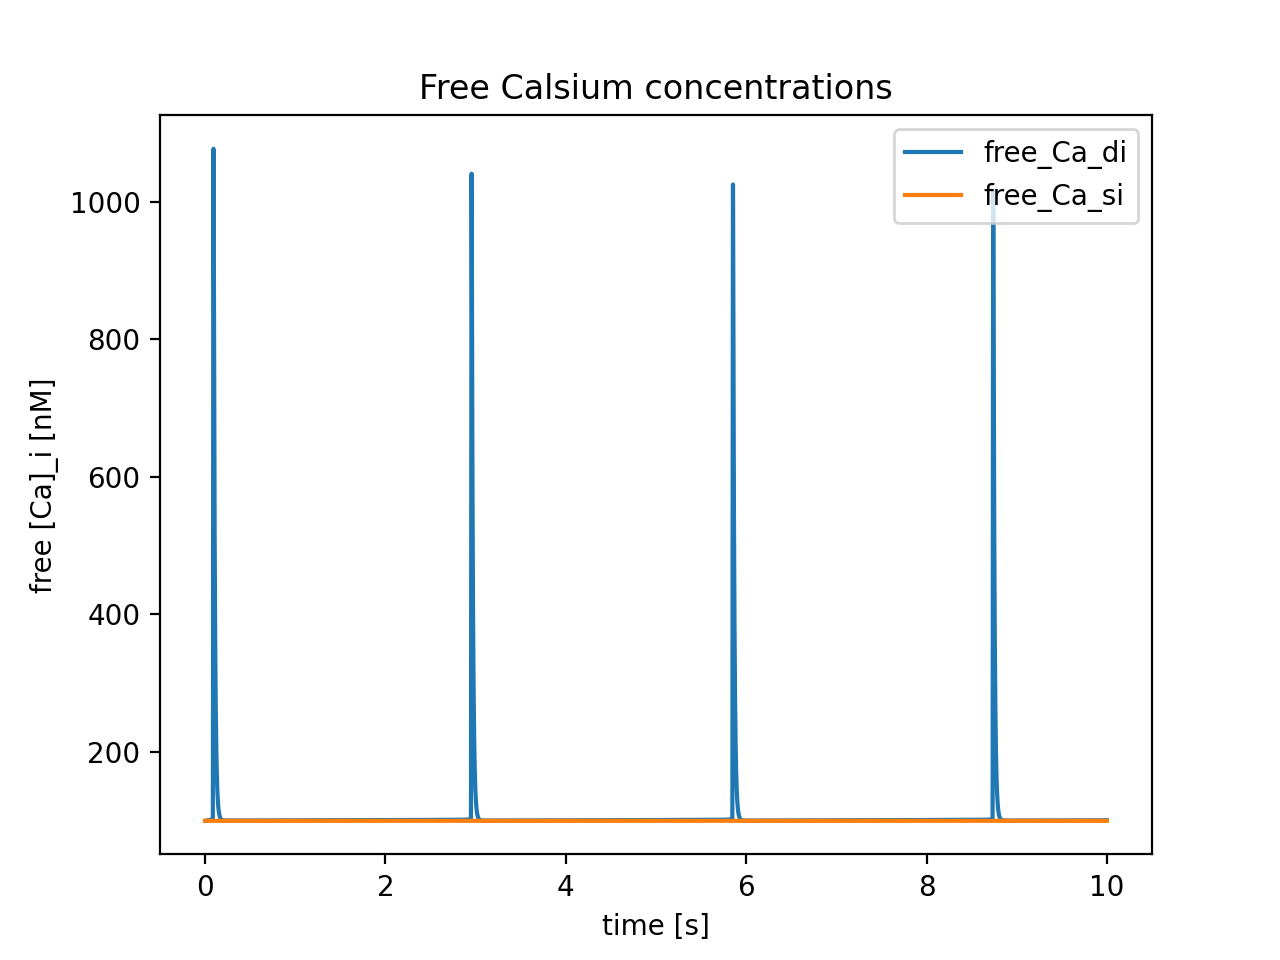

In [3]:
## Plot selected results


plt.close('all')
## plot results
f1 = plt.figure(1)
plt.plot(t, phi_sm*1000, '-', label='V_s')
plt.plot(t, phi_dm*1000, '-', label='V_d')
plt.title('Membrane potentials')
plt.xlabel('time [s]')
plt.ylabel('[mV]')
plt.legend()

## plot results
f2 = plt.figure(2)
plt.plot(t, phi_se*1000, '-', label='V_s')
#plt.plot(t, phi_de*1000, '-', label='V_d')
plt.title('Extracellular potentials')
plt.xlabel('time [s]')
plt.ylabel('[mV]')
plt.legend()

f5 = plt.figure(3)
plt.plot(t, Na_si, label='Na_si')
plt.plot(t, Na_se, label='Na_se')
plt.plot(t, Na_di, label='Na_di')
plt.plot(t, Na_de, label='Na_de')
plt.title('Sodium concentrations')
plt.xlabel('time [s]')
plt.legend()

f6 = plt.figure(4)
plt.plot(t, K_si, label='K_si')
plt.plot(t, K_se, label='K_se')
plt.plot(t, K_di, label='K_di')
plt.plot(t, K_de, label='K_de')
plt.title('Potassium concentrations')
plt.xlabel('time [s]')
plt.legend()

f7 = plt.figure(5)
plt.plot(t, Cl_si, label='Cl_si')
plt.plot(t, Cl_se, label='Cl_se')
plt.plot(t, Cl_di, label='Cl_di')
plt.plot(t, Cl_de, label='Cl_de')
plt.title('Chloride concentrations')
plt.xlabel('time [s]')
plt.legend()

f10 = plt.figure(6)
plt.plot(t, my_cell.free_Ca_di*1e6, label='free_Ca_di')
plt.plot(t, my_cell.free_Ca_si*1e6, label='free_Ca_si')
plt.title('Free Calsium concentrations')
plt.xlabel('time [s]')
plt.ylabel('free [Ca]_i [nM]')
plt.legend()

plt.show()